# Лабораторная работа №2 по курсу "Методы, средства и технологии мультимедиа"
Выполнил студент Шавандрин Фёдор

Группа М8О-408Б-19

## Задание
1. Написать валидацию на каждой эпохе
2. Написать расчет метрики IoU, (расчет должен быть векторным, выход тензор формы [BxC] где B - плоскость батча, С - класса)
3. Написать расчет метрики MIoU на основе IoU. Также представить IoU в среднем по датасету на последней валидации в развертке по классам. (пользоваться уже написанным IoU)
4. Обучить модель на приемлемое качество (хотя бы 25% MIoU на валидации). (Отбирать лучшее качество на валидации, отдельные запуски логировать в csv табличку: номер пуска: MIoU в среднем по классам)
5. Отобрать по 2 картинки на основе метрики IoU (усредненной по классам) из 3 квантилей по качеству: картинки, при ранжировании по качеству попадающие в первые 10%, в промежутке между 15% - 25%, и 45% - 55%. (пользоваться уже написанным IoU)
6. Отобрать лучшую по качеству IoU картинку по трем выбранным классам.
7. Посчитать таблицу IoU в развертке по кадому классу для лучшей модели.

- Таблицы, картинки, и ipynb-тетрадь собрать в архив. Картинки можно просто отобразить в тетради, уже без необходимости сохранения, как и таблицы. (Кроме таблицы с запусками, её приложить в архив).
- При обучении можете попробовать другие ФО, или аугментации. Модель тоже можете поменять.

In [1]:
import torch, torchvision
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

Имеем датасет VOC (Visual Object Classes). Подготовим датасет и реализуем класс для работы с ним.

In [2]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

## Аугментация данных
Будем использовать аугментацию данных с помощью библиотеки albumentations. Аугментация поможет нам повысить точность модели. Аугментировать будем обучающую и валидационную выборку.

In [3]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded

In [4]:
augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

In [5]:
val_augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

Посмотрим, из чего состоит наш датасет.

In [6]:
train_dataset = PascalVOCSearchDataset('.', image_set='train', download = True, transform = augs)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [7]:
val_dataset = train_dataset = PascalVOCSearchDataset('.', image_set='val', download = True, transform = val_augs)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [8]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([3, 256, 256]), torch.Size([21, 256, 256]))

Как видно, датасет состоит из картинки и лейблов.
Посмотрим на изображение из датасета.

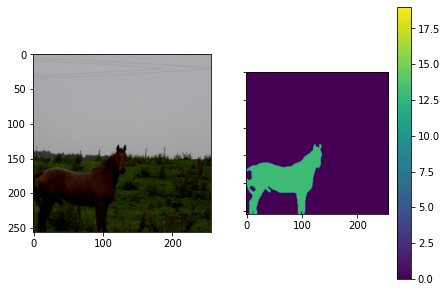

In [9]:
img,lbl = train_dataset[404]
fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
ax = ax.ravel()

ax[0].imshow(img.permute(1,2,0))
lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
plt.colorbar(lbl_plot,ax = ax[1])
plt.show()

## Реализация функций для подсчёта метрик IoU и MIoU

$IoU = \frac{pred ∩ real}{pred ∪ real}$

In [10]:
def calc_IoU(y_pred, y_real):
    # y_pred: [batch_size, classes_num, h, w]
    # y_real: [batch_size, classes_num, h, w]
    # output: [batch_size, classes_num]

    batch_size = y_real.shape[0]
    cls_num = y_real.shape[1]
    y_real = y_real.reshape(batch_size, cls_num, -1).long()
    y_pred = (F.one_hot(y_pred.argmax(axis=1), num_classes=cls_num).permute(0, 3, 1, 2).reshape(batch_size, cls_num, -1).long())
    
    # numerator
    intersection = (y_pred & y_real).sum(axis=-1)
    # denominator
    union = (y_pred | y_real).sum(axis=-1)
    iou = intersection / union
    return iou

Метрику MIoU (Mean IoU) будем считать в батчах как среднее значение метрики по всем классам, для которых IoU не NaN.

In [11]:
def calc_MIoU(y_pred, y_real):
    # y_pred: [batch_size, classes_num, h, w]
    # y_real: [batch_size, classes_num, h, w]
    # output: [batch_size, classes_num]
    
    iou = calc_IoU(y_pred, y_real)
    return iou.nanmean(axis=1)

## Обучение модели

In [12]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [13]:
model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
optim = torch.optim.AdamW(model.parameters(), lr = 3e-5, weight_decay = 1e-5)

In [15]:
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 2)

In [17]:
val_dataloader = DataLoader(val_dataset, batch_size=32, num_workers=2)

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [19]:
epochs = 5

train_losses = []
val_losses = []
train_miou = []
val_miou = []

model = model.to(device)

for epoch in tqdm(range(epochs)):
    # training
    cur_train_loss = 0
    cur_train_miou = 0
    train_samples_num = 0
    for images, labels in train_dataloader:
        train_samples_num += len(images)
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        preds = model(images)['out']
        loss = crit(preds, labels)
        cur_train_loss += loss.detach().cpu().item()
        cur_train_miou += calc_MIoU(preds.detach().cpu(), labels.detach().cpu()).sum()

        # backward pass
        loss.backward()
        optim.step()
        optim.zero_grad()
    
    train_losses.append(cur_train_loss / train_samples_num)
    train_miou.append(cur_train_miou / train_samples_num)

    # validation
    cur_val_loss = 0
    cur_val_miou = 0
    val_samples_num = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            val_samples_num += len(images)
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)['out']
            loss = crit(preds, labels)
            cur_val_loss += loss.detach().cpu().item()
            cur_val_miou += calc_MIoU(preds.detach().cpu(), labels.detach().cpu()).sum()
    
    val_losses.append(cur_val_loss / val_samples_num)
    val_miou.append(cur_val_miou / val_samples_num)

    print(f'Epoch {epoch+1}')
    print(f'Train loss: {train_losses[-1]:.3f}. Train MIoU: {train_miou[-1]:.3f}')
    print(f'Val loss: {val_losses[-1]:.3f}. Val MIoU: {val_miou[-1]:.3f}')

 20%|██        | 1/5 [09:21<37:27, 561.79s/it]

Epoch 1
Train loss: 0.012. Train MIoU: 0.573
Val loss: 0.010. Val MIoU: 0.588


 40%|████      | 2/5 [18:45<28:09, 563.16s/it]

Epoch 2
Train loss: 0.009. Train MIoU: 0.595
Val loss: 0.009. Val MIoU: 0.599


 60%|██████    | 3/5 [28:11<18:48, 564.21s/it]

Epoch 3
Train loss: 0.009. Train MIoU: 0.600
Val loss: 0.009. Val MIoU: 0.612


 80%|████████  | 4/5 [37:33<09:23, 563.28s/it]

Epoch 4
Train loss: 0.008. Train MIoU: 0.619
Val loss: 0.008. Val MIoU: 0.616


100%|██████████| 5/5 [46:49<00:00, 561.85s/it]

Epoch 5
Train loss: 0.008. Train MIoU: 0.626
Val loss: 0.008. Val MIoU: 0.623


Построим графики для лосса и MIoU на обучающей и валидационной выборке.

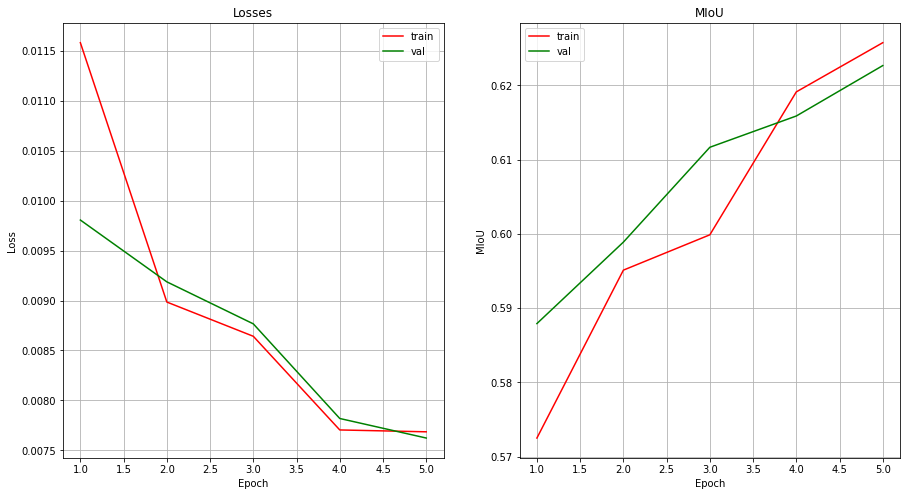

In [20]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='train', color='r')
plt.plot(range(1, epochs+1), val_losses, label='val', color='g')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_miou, label='train', color='r')
plt.plot(range(1, epochs+1), val_miou, label='val', color='g')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('MIoU')
plt.title('MIoU')

plt.show()

Как видно, метрика MIoU на валидацинной выборке не меньше 0.58.

## Визуальное представление работы модели

In [21]:
images, labels = next(iter(val_dataloader))
images = images.to(device)
labels = labels.to(device)
preds = model(images)['out']

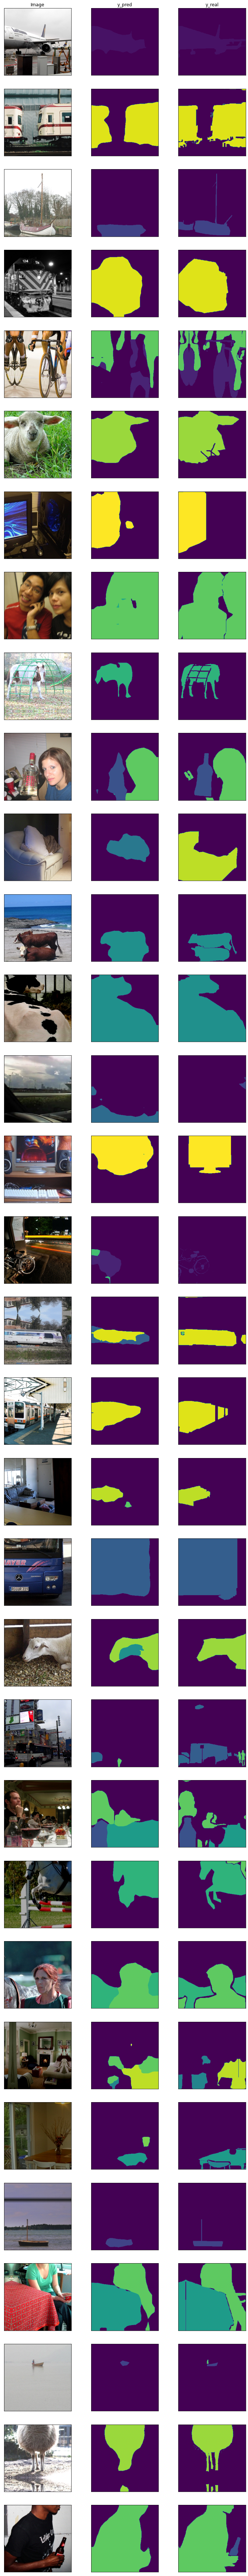

In [22]:
fig, axes = plt.subplots(len(images), 3, figsize=(12, len(images)*4))

for i, (img, pred, label) in enumerate(zip(images.detach().cpu(), preds.detach().cpu().softmax(1), labels.detach().cpu())):
    axes[i, 0].imshow(img.permute(1,2,0))
    axes[i, 1].imshow(pred.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)
    axes[i, 2].imshow(label.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.axes[0].set_title('Image')
fig.axes[1].set_title('y_pred')
fig.axes[2].set_title('y_real')

fig.show()

## IoU для каждого класса из датасета

Посмотрим на классы.

In [23]:
print(VOC_CLASSES)

['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']


Посчитаем IoU для каждого класса.

In [24]:
val_iou = None
val_miou = None

with torch.no_grad():
    for images, labels in tqdm(val_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)['out']
        iou = calc_IoU(preds.detach().cpu(), labels.detach().cpu())
        miou = calc_MIoU(preds.detach().cpu(), labels.detach().cpu())

        if val_iou is None:
            val_iou = iou.detach().cpu()
            val_miou = miou.detach().cpu()
        else:
            val_iou = torch.cat((val_iou, iou.detach().cpu()), dim=0)
            val_miou = torch.cat((val_miou, miou.detach().cpu()), dim=0)

100%|██████████| 46/46 [05:33<00:00,  7.24s/it]


Посмотрим на метрику IoU для всех классов и проведём сравнительный анализ.

In [25]:
for class_name, class_iou in zip(VOC_CLASSES, val_iou.nanmean(axis=1)):
    print(f'{class_name:13} {class_iou:.3f}')

background    0.747
aeroplane     0.857
bicycle       0.493
bird          0.447
boat          0.629
bottle        0.913
bus           0.936
car           0.893
cat           0.755
chair         0.816
cow           0.397
diningtable   0.842
dog           0.904
horse         0.248
motorbike     0.404
person        0.392
potted plant  0.489
sheep         0.487
sofa          0.175
train         0.367
tv/monitor    0.939


Как мы можем заметить, на некоторых классов (dog, bottle,  bus) метрика IoU достаточно высока (> 0.9), на других (sofa, horse) - низкая (около 0.2).

Для выполнения задания с выбором 2 картинок среди 3 классов:

- картинки, при ранжировании по качеству попадающие в первые 10%;
- картинки, при ранжировании по качеству попадающие в промежуток между 15% - 25%;
- картинки, при ранжировании по качеству попадающие в промежуток между 45% - 55%.

буду брать изображения, которые первыми попадаются в датасете.

In [26]:
quant_45 = torch.quantile(val_miou, 0.45).item()
quant_55 = torch.quantile(val_miou, 0.55).item()
quant_75 = torch.quantile(val_miou, 0.75).item()
quant_85 = torch.quantile(val_miou, 0.85).item()
quant_90 = torch.quantile(val_miou, 0.90).item()

In [27]:
imgs_cls1 = None
labels_cls1 = None
preds_cls1 = None

imgs_cls2 = None
labels_cls2 = None
preds_cls2 = None

imgs_cls3 = None
labels_cls3 = None
preds_cls3 = None

In [28]:
with torch.no_grad():
    for imgs, labels in val_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        preds = model(imgs)['out']
        miou = calc_MIoU(preds.detach().cpu(), labels.detach().cpu())
        for i in range(len(miou)):
          curr = miou[i].item()
          if quant_45 <= curr <= quant_55:
            if imgs_cls3 is None:
              imgs_cls3 = imgs[i].detach().cpu().unsqueeze(0)
              labels_cls3 = labels[i].detach().cpu().unsqueeze(0)
              preds_cls3 = preds[i].detach().cpu().unsqueeze(0)
            elif len(imgs_cls3) != 2:
              imgs_cls3 = torch.cat((imgs_cls3, imgs[i].detach().cpu().unsqueeze(0)), dim=0)
              labels_cls3 = torch.cat((labels_cls3, labels[i].detach().cpu().unsqueeze(0)), dim=0)
              preds_cls3 = torch.cat((preds_cls3, preds[i].detach().cpu().unsqueeze(0)), dim=0)
          elif quant_75 <= curr <= quant_85:
            if imgs_cls2 is None:
              imgs_cls2 = imgs[i].detach().cpu().unsqueeze(0)
              labels_cls2 = labels[i].detach().cpu().unsqueeze(0)
              preds_cls2 = preds[i].detach().cpu().unsqueeze(0)
            elif len(imgs_cls2) != 2:
              imgs_cls2 = torch.cat((imgs_cls2, imgs[i].detach().cpu().unsqueeze(0)), dim=0)
              labels_cls2 = torch.cat((labels_cls2, labels[i].detach().cpu().unsqueeze(0)), dim=0)
              preds_cls2 = torch.cat((preds_cls2, preds[i].detach().cpu().unsqueeze(0)), dim=0)
          elif quant_90 <= curr:
            if imgs_cls1 is None:
              imgs_cls1 = imgs[i].detach().cpu().unsqueeze(0)
              labels_cls1 = labels[i].detach().cpu().unsqueeze(0)
              preds_cls1 = preds[i].detach().cpu().unsqueeze(0)
            elif len(imgs_cls1) != 2:
              imgs_cls1 = torch.cat((imgs_cls1, imgs[i].detach().cpu().unsqueeze(0)), dim=0)
              labels_cls1 = torch.cat((labels_cls1, labels[i].detach().cpu().unsqueeze(0)), dim=0)
              preds_cls1 = torch.cat((preds_cls1, preds[i].detach().cpu().unsqueeze(0)), dim=0)
        if imgs_cls1 is not None and len(imgs_cls1) == 2 \
          and imgs_cls2 is not None and len(imgs_cls2) == 2 \
          and imgs_cls3 is not None and len(imgs_cls3) == 2:
          break

### Посмотрим на изображения, попавшие под первое условие (топ 10%)

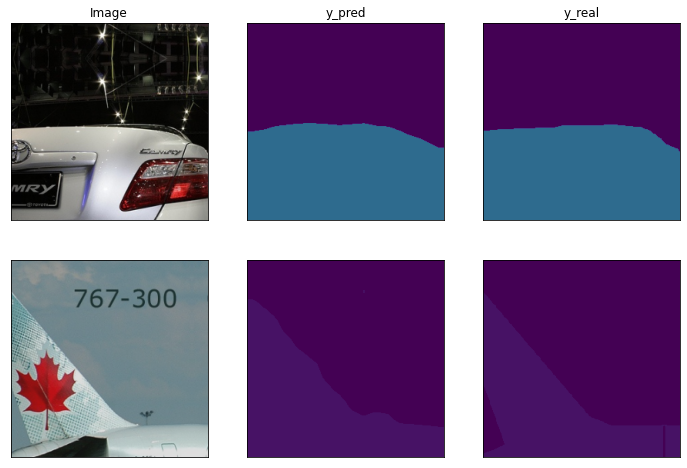

In [32]:
fig, axes = plt.subplots(len(imgs_cls1), 3, figsize=(12, len(imgs_cls1)*4))

for i, (img, pred, label) in enumerate(zip(imgs_cls1, preds_cls1.softmax(1), labels_cls1)):
    axes[i, 0].imshow(img.permute(1, 2, 0))
    axes[i, 1].imshow(pred.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)
    axes[i, 2].imshow(label.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.axes[0].set_title('Image')
fig.axes[1].set_title('y_pred')
fig.axes[2].set_title('y_real')

fig.show()

Как мы видим, наша модель практически точно сегментирует картинки из топ 10%.

### Изображения, попавшие под второе условие (15% - 25%)

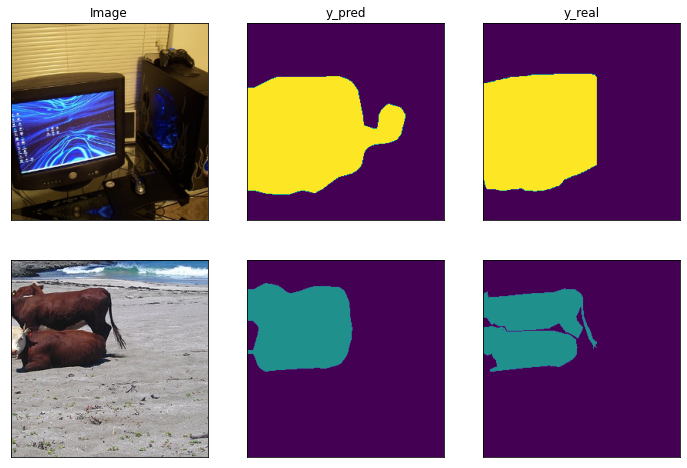

In [33]:
fig, axes = plt.subplots(len(imgs_cls2), 3, figsize=(12, len(imgs_cls2)*4))

for i, (img, pred, label) in enumerate(zip(imgs_cls2, preds_cls2.softmax(1), labels_cls2)):
    axes[i, 0].imshow(img.permute(1,2,0))
    axes[i, 1].imshow(pred.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)
    axes[i, 2].imshow(label.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.axes[0].set_title('Image')
fig.axes[1].set_title('y_pred')
fig.axes[2].set_title('y_real')

fig.show()

Данные картинки также сегментируются достаточно хорошо, но уже видны проблемы распознавания границ некоторых объектов.

### Изображения, попавшие под второе условие (45% - 55%)

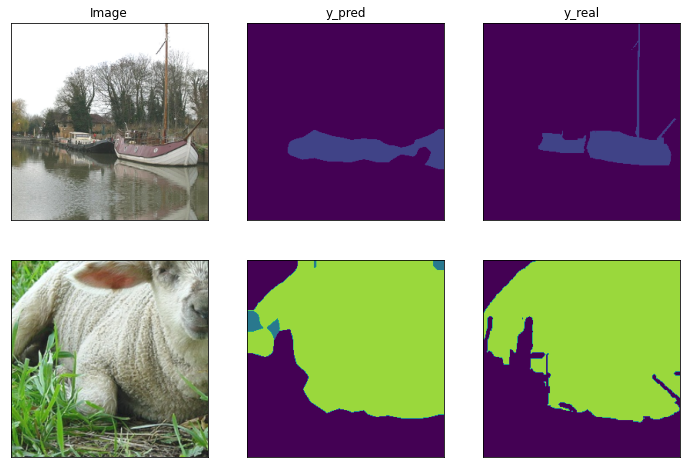

In [34]:
fig, axes = plt.subplots(len(imgs_cls3), 3, figsize=(12, len(imgs_cls3)*4))

for i, (img, pred, label) in enumerate(zip(imgs_cls3, preds_cls3.softmax(1), labels_cls3)):
    axes[i, 0].imshow(img.permute(1,2,0))
    axes[i, 1].imshow(pred.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)
    axes[i, 2].imshow(label.argmax(0), vmin=0, vmax=len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.axes[0].set_title('Image')
fig.axes[1].set_title('y_pred')
fig.axes[2].set_title('y_real')

fig.show()

Картинки в топ 45%-55% сегментируются плохо по сравнению с картинками из топ 10%: некоторые объекты модель относит к другим классам.
## Выводы
В ходе данной лабораторной работе решал задачу семантической сегментации с использованием датасета Pascal VOC. Использовал аугментацию данных для улучшения качества модели, реализовал функции подсчёта метрики IoU и MIoU. При обучении использовал 5 эпох, при этом метрика IoU на валидационной выборке была не менее 0.59.